In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 制作数据集
# 数据集转换参数
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
])
# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'D:/Jupyter/dataset/mnist/', # 下载路径
    train = True, # 是 train 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)
test_Data = datasets.MNIST(
    root = 'D:/Jupyter/dataset/mnist/', # 下载路径
    train = False, # 是 test 集
    download = True, # 如果该路径没有该数据集，就下载
    transform = transform # 数据集转换参数
)

In [4]:
# 批次加载器
train_loader = DataLoader(dataset=train_Data, shuffle=True, batch_size=64)
test_loader = DataLoader(dataset=test_Data, shuffle=False, batch_size=32)

In [5]:
# 搭建神经网络
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()
        self.net = nn.Sequential(   # 按顺序搭建各层
            nn.Flatten(),                    # 把图像铺平成一维
            nn.Linear(784, 512), nn.ReLU(),  # 第 1 层：全连接层
            nn.Linear(512, 256), nn.ReLU(),  # 第 2 层：全连接层
            nn.Linear(256, 128), nn.ReLU(),  # 第 3 层：全连接层
            nn.Linear(128, 64), nn.ReLU(),   # 第 4 层：全连接层
            nn.Linear(64, 10)                # 第 5 层：全连接层
        )

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)  # x 即输入数据, 这里的net和__init__()中的net要一致，自己起名
        return y         # y 即输出数据

In [6]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [7]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss() # 自带 softmax 激活函数

In [8]:
# 优化算法的选择
learning_rate = 0.01 # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    momentum = 0.5   
)

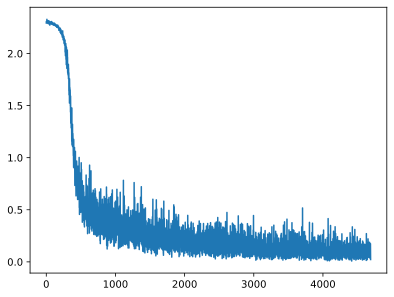

In [9]:
# 训练网络
epochs = 5
losses = [] # 记录损失函数变化的列表

for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
        
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [10]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 96.22000122070312 %


In [11]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('cuda:0'), y.to('cuda:0')   
        Pred = model(x) # 一次前向传播（小批量）
        print(Pred.type(), y.type())  
        print(Pred.shape, y.shape)       
        _, predicted = torch.max(Pred.data, dim=1)
        print(predicted.type(), y.type())  
        print(predicted.shape, y.shape)      
        print((predicted == y).all(1).type())   
        print((predicted == y).all(1).shape)    
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
print(f'测试集精准度: {100*correct/total} %')

torch.cuda.FloatTensor torch.cuda.LongTensor
torch.Size([32, 10]) torch.Size([32])
torch.cuda.LongTensor torch.cuda.LongTensor
torch.Size([32]) torch.Size([32])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)